In [1]:
import numpy as np
import pandas as pd
import findspark
findspark.init()
import pyspark
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import google

In [2]:
spark=SparkSession.builder.appName('911 Portfolio').getOrCreate()

In [2]:
pd_df=pd.read_csv('911.csv')
#df=spark.read.csv('911.csv' , inferSchema=True, header = True)
#df=spark.createDataFrame(pd_df)

In [13]:
df.toPandas().head()

,lat,lng,desc,zip,title,timeStamp,twp,addr,e
0,40.297876,-75.581294,REINDEER CT & DEAD END; NEW HANOVER; Station ...,19525.0,EMS: BACK PAINS/INJURY,2015-12-10 17:40:00,NEW HANOVER,REINDEER CT & DEAD END,1
1,40.258061,-75.264680,BRIAR PATH & WHITEMARSH LN; HATFIELD TOWNSHIP...,19446.0,EMS: DIABETIC EMERGENCY,2015-12-10 17:40:00,HATFIELD TOWNSHIP,BRIAR PATH & WHITEMARSH LN,1
2,40.121182,-75.351975,HAWS AVE; NORRISTOWN; 2015-12-10 @ 14:39:21-St...,19401.0,Fire: GAS-ODOR/LEAK,2015-12-10 17:40:00,NORRISTOWN,HAWS AVE,1
3,40.116153,-75.343513,AIRY ST & SWEDE ST; NORRISTOWN; Station 308A;...,19401.0,EMS: CARDIAC EMERGENCY,2015-12-10 17:40:01,NORRISTOWN,AIRY ST & SWEDE ST,1
4,40.251492,-75.603350,CHERRYWOOD CT & DEAD END; LOWER POTTSGROVE; S...,NaN,EMS: DIZZINESS,2015-12-10 17:40:01,LOWER POTTSGROVE,CHERRYWOOD CT & DEAD END,1


In [5]:
df.toPandas().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99492 entries, 0 to 99491
Data columns (total 9 columns):
lat          99492 non-null float64
lng          99492 non-null float64
desc         99492 non-null object
zip          86637 non-null float64
title        99492 non-null object
timeStamp    99492 non-null datetime64[ns]
twp          99449 non-null object
addr         98973 non-null object
e            99492 non-null int32
dtypes: datetime64[ns](1), float64(3), int32(1), object(4)
memory usage: 6.5+ MB


In [17]:
df.toPandas().describe()

,lat,lng,zip,e
count,99492.000000,99492.000000,86637.000000,99492.0
mean,40.159526,-75.317464,19237.658298,1.0
std,0.094446,0.174826,345.344914,0.0
min,30.333596,-95.595595,17752.000000,1.0
25%,40.100423,-75.392104,19038.000000,1.0
50%,40.145223,-75.304667,19401.000000,1.0
75%,40.229008,-75.212513,19446.000000,1.0
max,41.167156,-74.995041,77316.000000,1.0


In [7]:
df.groupby('title').count().orderBy('count', ascending = False).show()

+--------------------+-----+
|               title|count|
+--------------------+-----+
|Traffic: VEHICLE ...|23066|
|Traffic: DISABLED...| 7702|
|    Fire: FIRE ALARM| 5496|
|EMS: RESPIRATORY ...| 5112|
|EMS: CARDIAC EMER...| 5012|
|    EMS: FALL VICTIM| 4863|
|EMS: VEHICLE ACCI...| 3935|
|Traffic: ROAD OBS...| 3144|
|EMS: SUBJECT IN PAIN| 2687|
|    EMS: HEAD INJURY| 2631|
|EMS: UNKNOWN MEDI...| 1873|
|EMS: SYNCOPAL EPI...| 1717|
|Fire: VEHICLE ACC...| 1638|
|       EMS: SEIZURES| 1630|
|EMS: GENERAL WEAK...| 1464|
|Fire: FIRE INVEST...| 1460|
|EMS: ABDOMINAL PAINS| 1436|
|EMS: ALTERED MENT...| 1386|
|EMS: MEDICAL ALER...| 1342|
|   EMS: HEMORRHAGING| 1259|
+--------------------+-----+
only showing top 20 rows



In [5]:
#df.drop_duplicates(keep='first', inplace=True)

In [4]:
#pd_df.isna().sum()
# pyspark check isnan or isnull only for int and double types of cols
df.select([F.count(F.when(F.isnan(col) | F.isnull(col), col)).alias(col) for (col, ctype) in df.dtypes if ctype not in ('string', 'timestamp')]).show()

+---+---+-----+---+
|lat|lng|  zip|  e|
+---+---+-----+---+
|  0|  0|12855|  0|
+---+---+-----+---+



In [5]:
#df['specific_reason']=df['title'].apply(lambda a:a.split(':')[0])
#df['time']=df['timeStamp'].apply(lambda a:a.split(' ')[-1])
#df['month']=df['timeStamp'].apply(lambda a:a.split(' ')[0].split('-')[1])
df=df.withColumn('specific_reason', F.split(F.col('title'), ':').getItem(0))
df=df.withColumn('month', F.split(F.split(F.col('timeStamp'), ' ').getItem(0), '-').getItem(1))

In [7]:
df.toPandas().head(5)

,lat,lng,desc,zip,title,timeStamp,twp,addr,e,specific_reason,month
0,40.297876,-75.581294,REINDEER CT & DEAD END; NEW HANOVER; Station ...,19525.0,EMS: BACK PAINS/INJURY,2015-12-10 17:40:00,NEW HANOVER,REINDEER CT & DEAD END,1,EMS,12
1,40.258061,-75.264680,BRIAR PATH & WHITEMARSH LN; HATFIELD TOWNSHIP...,19446.0,EMS: DIABETIC EMERGENCY,2015-12-10 17:40:00,HATFIELD TOWNSHIP,BRIAR PATH & WHITEMARSH LN,1,EMS,12
2,40.121182,-75.351975,HAWS AVE; NORRISTOWN; 2015-12-10 @ 14:39:21-St...,19401.0,Fire: GAS-ODOR/LEAK,2015-12-10 17:40:00,NORRISTOWN,HAWS AVE,1,Fire,12
3,40.116153,-75.343513,AIRY ST & SWEDE ST; NORRISTOWN; Station 308A;...,19401.0,EMS: CARDIAC EMERGENCY,2015-12-10 17:40:01,NORRISTOWN,AIRY ST & SWEDE ST,1,EMS,12
4,40.251492,-75.603350,CHERRYWOOD CT & DEAD END; LOWER POTTSGROVE; S...,NaN,EMS: DIZZINESS,2015-12-10 17:40:01,LOWER POTTSGROVE,CHERRYWOOD CT & DEAD END,1,EMS,12


In [11]:
df.groupBy('specific_reason').count().show()

+---------------+-----+
|specific_reason|count|
+---------------+-----+
|            EMS|48877|
|           Fire|14920|
|        Traffic|35695|
+---------------+-----+



In [12]:
df.groupby('month').agg(F.count('specific_reason')).show()

+-----+----------------------+
|month|count(specific_reason)|
+-----+----------------------+
|   07|                 12137|
|   01|                 13205|
|   05|                 11423|
|   08|                  9078|
|   03|                 11101|
|   02|                 11467|
|   06|                 11786|
|   12|                  7969|
|   04|                 11326|
+-----+----------------------+



### visualization

In [212]:
df.toPandas().hist

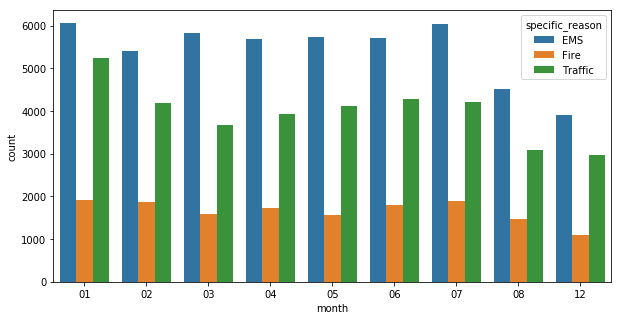

In [233]:
plt.figure(figsize=(10,5))
sns.countplot(x='month', data=df, hue='specific_reason')
plt.show()

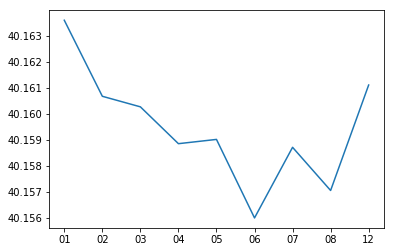

In [234]:
plt.plot(df.groupby('month')['lat'].mean())
plt.show()

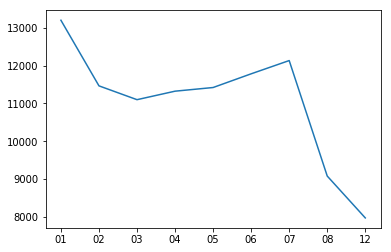

In [240]:
plt.plot(by_month['lat'])
plt.show()

In [11]:
#df.to_csv('911_data_processed.csv')

In [10]:
df.toPandas().to_csv('911_data_processed.csv')

In [7]:
pd_df[['lat','lng']].values

array([[ 40.2978759, -75.5812935],
       [ 40.2580614, -75.2646799],
       [ 40.1211818, -75.3519752],
       ...,
       [ 40.115429 , -75.3346793],
       [ 40.1864308, -75.1925553],
       [ 40.2070553, -75.3179522]])

In [8]:
19525

'REINDEER CT & DEAD END'